Using the cms_synthetic_claims.db from https://github.com/theradler/Hackathon25/tree/main/cms_synthetic_claims. Change the path to be your path

In [97]:
import pandas as pd
import sqlite3

# Connect to the local SQLite database
conn = sqlite3.connect('C:\\Workspace\\hack2\\Hackathon25-robert\\cms_synthetic_claims\\cms_synthetic_claims.db')

# Run the PRAGMA table_info command for each table
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
for table in tables['name']:
    info = pd.read_sql_query(f"PRAGMA table_info({table});", conn)
    print(f"Table: {table}")
    print(info)
    print()

df_inpatient_claims = pd.read_sql_query("SELECT * FROM raw_cms_claims;", conn)
conn.close()

Table: raw_cms_claims
     cid                         name       type  notnull dflt_value  pk
0      0                      BENE_ID    INTEGER        0       None   0
1      1                       CLM_ID    INTEGER        0       None   0
2      2   NCH_NEAR_LINE_REC_IDENT_CD       TEXT        0       None   0
3      3              NCH_CLM_TYPE_CD    INTEGER        0       None   0
4      4                  CLM_FROM_DT  TIMESTAMP        0       None   0
..   ...                          ...        ...      ...        ...  ..
192  192     CLM_UNCOMPD_CARE_PMT_AMT       REAL        0       None   0
193  193                 CLM_LINE_NUM    INTEGER        0       None   0
194  194                     REV_CNTR    INTEGER        0       None   0
195  195                     HCPCS_CD       TEXT        0       None   0
196  196  REV_CNTR_DDCTBL_COINSRNC_CD       REAL        0       None   0

[197 rows x 6 columns]

Table: raw_cms_beneficiary_2025
     cid               name       type  notnu

In [98]:
#  this removal process is slow, lets build up what we want to keep instead
# df_inpatient_claims = df_inpatient_claims.drop(columns=['NCH_NEAR_LINE_REC_IDENT_CD']) # always 'V' because this is inpatient claims
# df_inpatient_claims = df_inpatient_claims.drop(columns=['NCH_CLM_TYPE_CD']) # always 60 because this is inpatient claims
# df_inpatient_claims = df_inpatient_claims.drop(columns=['FI_CLM_PROC_DT']) # always empty, The date the fiscal intermediary completes processing and releases the institutional claim
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLAIM_QUERY_CODE']) # always 3 Code indicating the type of claim record being processed with respect to payment. 3 is the final bill
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_FAC_TYPE_CD']) # always 1, 'Hospital' https://bluebutton.cms.gov/resources/variables/clm_fac_type_cd/
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_SRVC_CLSFCTN_TYPE_CD']) # always 1, related to the above
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_FREQ_CD']) # always 1, Admit thru discharge claim, https://resdac.org/cms-data/variables/claim-frequency-code-ffs
# df_inpatient_claims = df_inpatient_claims.drop(columns=['FI_NUM']) # always blank https://resdac.org/cms-data/variables/fi-or-mac-number
# df_inpatient_claims = df_inpatient_claims.drop(columns=['CLM_MDCR_NON_PMT_RSN_CD']) # always blank https://resdac.org/cms-data/variables/claim-medicare-non-payment-reason-code

# Select a subset of columns to keep
columns_to_keep = [
    'BENE_ID', # unique beneficiary identifier
    'CLM_ID', # unique claim identifier
    'CLM_FROM_DT', # claim start date
    'CLM_THRU_DT', # claim through date
    # 'PRVDR_NUM', # provider identifier number
    # 'CLM_PMT_AMT', # claim payment amount
    # 'NCH_PRMRY_PYR_CLM_PD_AMT', # amount paid by primary payer
    # 'FI_CLM_ACTN_CD', always blank The type of action requested by the intermediary to be taken on an institutional claim.
    # 'PRVDR_STATE_CD', # state code of the provider, not helpful really
    # 'ORG_NPI_NUM',  # The National Provider Identifier (NPI) of the organization or group practice.
    # 'AT_PHYSN_NPI', # Claim Attending Physician NPI Number
    # 'OP_PHYSN_NPI', # Claim Operating Physician NPI Number
    # 'OT_PHYSN_NPI', # Claim Other Physician NPI Number, always blank
    # 'PTNT_DSCHRG_STUS_CD', # Patient Discharge Status Code, always 1
    # 'CLM_TOT_CHRG_AMT',  # Claim Total Charge Amount
    # 'CLM_ADMSN_DT',  # Claim Admission Date
    'CLM_IP_ADMSN_TYPE_CD', # The code indicating the type and priority of an inpatient admission associated with the service on an intermediary submitted claim. 
    'CLM_SRC_IP_ADMSN_CD', # The code indicating the source of the referral for the admission or visit.
    'NCH_PTNT_STATUS_IND_CD', # The code indicating the source of the referral for the admission or visit.
    # 'CLM_PASS_THRU_PER_DIEM_AMT', always the same, Claim Pass Thru Per Diem Amount
    # 'NCH_BENE_IP_DDCTBL_AMT', # The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the institutional claim.
    # 'PRNCPAL_DGNS_CD', # The principal diagnosis code for the claim.  THIS ONE IS ADDED LATER
]

# Add additional diagnosis codes and other codes that could impact length of stay
# what to do about 1 bene having multiple claims?

df_inpatient_subset = df_inpatient_claims[columns_to_keep].copy()

# Add a new column for the number of days between CLM_FROM_DT and CLM_THRU_DT
df_inpatient_subset['CLM_NUM_DAYS'] = (
    pd.to_datetime(df_inpatient_subset['CLM_THRU_DT']) - pd.to_datetime(df_inpatient_subset['CLM_FROM_DT'])
).dt.days



In [99]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_NUM_DAYS
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,1,4,A,0
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,1,2,A,0
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,3,1,A,1
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,1,4,A,0
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,1,4,A,0
...,...,...,...,...,...,...,...,...
58061,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,3,5,A,6
58062,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,1,2,A,0
58063,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,1,4,A,1
58064,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,2,1,A,3


In [100]:
# add the diagnosis codes
# Add all ICD_DGNS_CD1-25 and CLM_POA_IND_SW1-25 columns from df_inpatient_claims to df_inpatient_subset

# Identify the columns to add
diagnosis_cols = [f'ICD_DGNS_CD{i}' for i in range(1, 26)]
poa_cols = [f'CLM_POA_IND_SW{i}' for i in range(1, 26)]

# Only keep columns that exist in df_inpatient_claims
diagnosis_cols = [col for col in diagnosis_cols if col in df_inpatient_claims.columns]
poa_cols = [col for col in poa_cols if col in df_inpatient_claims.columns]

# Create a new column that concatenates all diagnosis codes for each claim into a single string
df_inpatient_subset['ALL_DGNS_CODES'] = df_inpatient_claims[diagnosis_cols].astype(str).agg('|'.join, axis=1)

# Add these columns to the subset DataFrame
df_inpatient_subset = pd.concat(
    [df_inpatient_subset, df_inpatient_claims[diagnosis_cols + poa_cols].reset_index(drop=True)],
    axis=1
)

In [101]:
# df_inpatient_subset.head()
df_inpatient_subset

,BENE_ID,CLM_ID,CLM_FROM_DT,CLM_THRU_DT,CLM_IP_ADMSN_TYPE_CD,CLM_SRC_IP_ADMSN_CD,NCH_PTNT_STATUS_IND_CD,CLM_NUM_DAYS,ALL_DGNS_CODES,ICD_DGNS_CD1,...,CLM_POA_IND_SW16,CLM_POA_IND_SW17,CLM_POA_IND_SW18,CLM_POA_IND_SW19,CLM_POA_IND_SW20,CLM_POA_IND_SW21,CLM_POA_IND_SW22,CLM_POA_IND_SW23,CLM_POA_IND_SW24,CLM_POA_IND_SW25
0,-10000010254618,-10000930037831,2015-03-25 00:00:00,2015-03-25 00:00:00,1,4,A,0,S134XX|R4689|E781|J329|E119|D649|E849|B965|N46...,S134XX,...,None,None,None,None,None,None,None,None,None,None
1,-10000010254653,-10000930038030,2015-09-24 00:00:00,2015-09-24 00:00:00,1,2,A,0,T7432X|E669|C50919|None|None|None|None|None|No...,T7432X,...,None,None,None,None,None,None,None,None,None,None
2,-10000010254653,-10000930038031,2017-05-09 00:00:00,2017-05-10 00:00:00,3,1,A,1,T7432X|E669|C50929|None|None|None|None|None|No...,T7432X,...,None,None,None,None,None,None,None,None,None,None
3,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,1,4,A,0,S8290X|G40909|R569|Z8669|None|None|None|None|N...,S8290X,...,None,None,None,None,None,None,None,None,None,None
4,-10000010254656,-10000930038162,2017-01-14 00:00:00,2017-01-14 00:00:00,1,4,A,0,S8290X|G40909|R569|Z8669|None|None|None|None|N...,S8290X,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,-10000010288008,-10000931485965,2020-01-08 00:00:00,2020-01-14 00:00:00,3,5,A,6,T7432X|T50901A|J329|R931|I259|G43719|K011|R52|...,T7432X,...,None,None,None,None,None,None,None,None,None,None
58062,-10000010288008,-10000931485967,2020-10-23 00:00:00,2020-10-23 00:00:00,1,2,A,0,Z733|F0280|T50901A|J329|R931|I259|G43719|K011|...,Z733,...,None,None,None,None,None,None,None,None,None,None
58063,-10000010288008,-10000931485969,2021-08-22 00:00:00,2021-08-23 00:00:00,1,4,A,1,Z608|Z733|G309|T50901A|J329|R931|I259|G43719|K...,Z608,...,None,None,None,None,None,None,None,None,None,None
58064,-10000010288008,-10000931485971,2021-09-13 00:00:00,2021-09-16 00:00:00,2,1,A,3,Z608|Z733|F0280|T50901A|J329|R931|I259|G43719|...,Z608,...,None,None,None,None,None,None,None,None,None,None


In [102]:
# Use target/mean encoding to encode the diagnosis codes based on average length of stay
# For each unique diagnosis code value across all ICD_DGNS_CD1-25 columns,
# compute the mean CLM_NUM_DAYS and add a new column for each ICD_DGNS_CD column with the encoded value

# Get all unique codes across all 25 columns
all_codes = pd.unique(df_inpatient_subset[diagnosis_cols].values.ravel())

# I THINK PRNCPAL_DGNS_CD should be included in this analysis as well, maybe with a stronger weight??
# THIS DOESN"T FACTOR IN THE POA CODES, SHOULD IT? It probably should
# The TMEAN is being used as a feature without enough conext based on the reuse of codes across columns, this needs to be fixed

# Build a mapping: code -> mean CLM_NUM_DAYS (across any column)
diag_code_Tmeans = {}
for code in all_codes:
    if pd.isna(code) or code == 'None':
        continue
    mask = (df_inpatient_subset[diagnosis_cols] == code).any(axis=1)
    diag_code_Tmeans[code] = df_inpatient_subset.loc[mask, 'CLM_NUM_DAYS'].mean()

# For each diagnosis column, map the code to the mean value
for col in diagnosis_cols:
    df_inpatient_subset[f'{col}_TMEAN'] = df_inpatient_subset[col].map(diag_code_Tmeans)


In [ ]:
# df_inpatient_subset.head()
# df_inpatient_subset.describe()
df_inpatient_subset
# diag_code_Tmeans
# df_inpatient_subset[['BENE_ID', 'CLM_NUM_DAYS', 'ICD_DGNS_CD1', 'ICD_DGNS_CD1_TMEAN', 'ALL_DGNS_CODES']].head()


,BENE_ID,CLM_NUM_DAYS,ICD_DGNS_CD1,ICD_DGNS_CD1_TMEAN,ALL_DGNS_CODES
0,-10000010254618,0,S134XX,0.578788,S134XX|R4689|E781|J329|E119|D649|E849|B965|N46...
1,-10000010254653,0,T7432X,1.712748,T7432X|E669|C50919|None|None|None|None|None|No...
2,-10000010254653,1,T7432X,1.712748,T7432X|E669|C50929|None|None|None|None|None|No...
3,-10000010254656,0,S8290X,0.057389,S8290X|G40909|R569|Z8669|None|None|None|None|N...
4,-10000010254656,0,S8290X,0.057389,S8290X|G40909|R569|Z8669|None|None|None|None|N...


In [ ]:
# import matplotlib.pyplot as plt

# # Group by principal diagnosis code and calculate mean and count of treatment days
# diagnosis_days = (
#     df_inpatient_subset
#     .groupby('ALL_DGNS_CODES')['CLM_NUM_DAYS']
#     .agg(['mean', 'count', 'min', 'max', 'std'])
#     .sort_values('std', ascending=False)
# )

# diagnosis_days

In [ ]:

# code = 'T7432X'
# length_stays = df_inpatient_subset[df_inpatient_subset['ICD_DGNS_CD1'] == code]['CLM_NUM_DAYS']

# length_stays = length_stays[length_stays != 0]

# length_stays.hist()

In [ ]:
# length_stays = df_inpatient_subset[df_inpatient_subset['ICD_DGNS_CD1'] == code]['CLM_NUM_DAYS']

# length_stays = length_stays[length_stays != 0]

# # Calculate mean and std
# mean_days = length_stays.mean()
# std_days = length_stays.std()

# # Scatter plot
# plt.figure(figsize=(12, 4))
# plt.scatter(range(len(length_stays)), length_stays, alpha=0.5, label='CLM_NUM_DAYS')
# plt.axhline(mean_days, color='red', linestyle='--', label=f'Mean ({mean_days:.2f})')
# plt.axhline(mean_days + std_days, color='green', linestyle=':', label=f'+1 Std ({mean_days + std_days:.2f})')
# plt.axhline(mean_days - std_days, color='green', linestyle=':', label=f'-1 Std ({mean_days - std_days:.2f})')
# plt.axhline(mean_days + 2*std_days, color='orange', linestyle='-.', label=f'+2 Std ({mean_days + 2*std_days:.2f})')
# plt.axhline(mean_days - 2*std_days, color='orange', linestyle='-.', label=f'-2 Std ({mean_days - 2*std_days:.2f})')
# plt.title('CLM_NUM_DAYS for ICD_DGNS_CD1 = Z733')
# plt.xlabel('Claim Index')
# plt.ylabel('CLM_NUM_DAYS')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# # Using isolation forest to identify outliers in length of stay for a specific diagnosis code
# # This only factors in ICD_DGNS_CD1 and CLM_NUM_DAYS the other features are not added in yet

# from sklearn.ensemble import IsolationForest
# import numpy as np

# stays_rs = df_inpatient_subset[df_inpatient_subset['ICD_DGNS_CD1'] == code]['CLM_NUM_DAYS'].values.reshape(-1, 1)

# iso = IsolationForest(random_state=42, contamination='auto')
# iso = iso.fit(stays_rs)

# # For a single feature, DecisionBoundaryDisplay will show the threshold(s) as vertical lines.
# # Let's plot the data and the decision function for the 1D case.
# plt.figure(figsize=(8, 4))
# plt.scatter(stays_rs, np.zeros_like(stays_rs), c=iso.predict(stays_rs), cmap='coolwarm', s=30, edgecolor='k', label='Samples')
# xx = np.linspace(stays_rs.min(), stays_rs.max(), 500).reshape(-1, 1)
# decision = iso.decision_function(xx)
# plt.plot(xx, decision, color='black', lw=2, label='Decision function')
# plt.axhline(0, color='red', linestyle='--', label='Decision threshold')
# plt.xlabel('CLM_NUM_DAYS')
# plt.title(f'Isolation Forest Decision Function for {code}')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# df_inpatient_subset

In [ ]:
testData = df_inpatient_subset.copy()

# SPLIT YA DATA MATE!

In [112]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


# Prepare feature columns (all ICD_DGNS_CD[1:25]_TMEAN)
tmean_cols = [f'ICD_DGNS_CD{i}_TMEAN' for i in range(1, 26)]

# Drop rows with missing values in features or target
# Select only the tmean_cols and CLM_NUM_DAYS, and drop rows with missing values
rf_data = testData[tmean_cols + ['CLM_NUM_DAYS']]

# rf_data

X = rf_data[tmean_cols]
y = rf_data['CLM_NUM_DAYS']

# X

# Fit RandomForestRegressor on all data
rf = RandomForestRegressor(random_state=42)
rf.fit(X, y)

# Predict on the same data and evaluate
y_pred = rf.predict(X)

# Add predictions to the DataFrame
df_inpatient_subset.loc[rf_data.index, 'CLM_NUM_DAYS_RF_PRED'] = y_pred



In [113]:
# Show a comparison of prediction vs actual
df_inpatient_subset[tmean_cols + ['CLM_NUM_DAYS', 'CLM_NUM_DAYS_RF_PRED']]

,ICD_DGNS_CD1_TMEAN,ICD_DGNS_CD2_TMEAN,ICD_DGNS_CD3_TMEAN,ICD_DGNS_CD4_TMEAN,ICD_DGNS_CD5_TMEAN,ICD_DGNS_CD6_TMEAN,ICD_DGNS_CD7_TMEAN,ICD_DGNS_CD8_TMEAN,ICD_DGNS_CD9_TMEAN,ICD_DGNS_CD10_TMEAN,...,ICD_DGNS_CD18_TMEAN,ICD_DGNS_CD19_TMEAN,ICD_DGNS_CD20_TMEAN,ICD_DGNS_CD21_TMEAN,ICD_DGNS_CD22_TMEAN,ICD_DGNS_CD23_TMEAN,ICD_DGNS_CD24_TMEAN,ICD_DGNS_CD25_TMEAN,CLM_NUM_DAYS,CLM_NUM_DAYS_RF_PRED
0,0.578788,2.319571,0.771015,1.739297,0.753105,1.981972,0.333333,0.181818,0.000000,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.916667
1,1.712748,1.914883,1.157045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.183667
2,1.712748,1.914883,1.241019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.667500
3,0.057389,1.291562,1.242382,1.447528,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
4,0.057389,1.291562,1.242382,1.447528,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58061,1.712748,2.339233,1.739297,1.386238,1.372449,1.970926,2.426332,2.380804,1.914883,2.786958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,5.259167
58062,1.762503,0.345082,2.339233,1.739297,1.386238,1.372449,1.970926,2.426332,2.380804,1.914883,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.530000
58063,1.830738,1.762503,0.355482,2.339233,1.739297,1.386238,1.372449,1.970926,2.426332,2.380804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.700000
58064,1.830738,1.762503,0.345082,2.339233,1.739297,1.386238,1.372449,1.970926,2.426332,2.380804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,2.580000


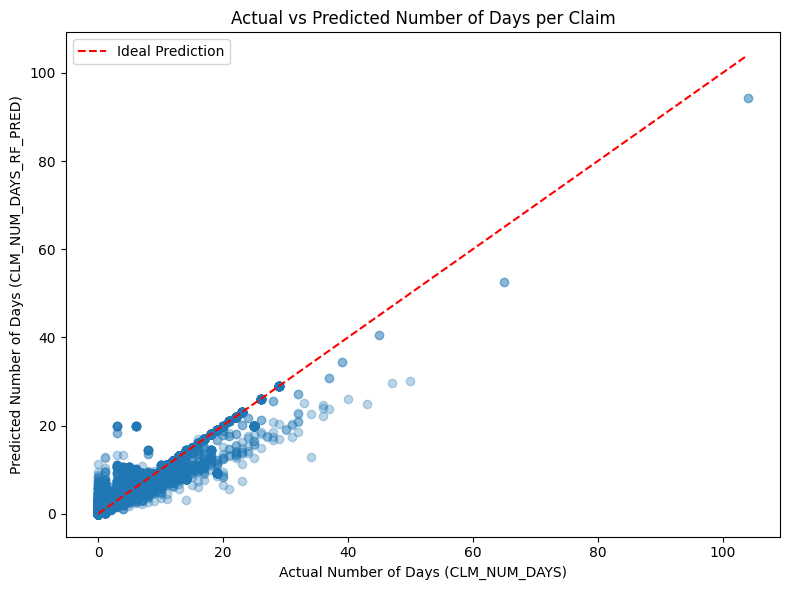

In [114]:
# plot the clm_num_days and the predicted num of days for each claim

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(df_inpatient_subset['CLM_NUM_DAYS'], df_inpatient_subset['CLM_NUM_DAYS_RF_PRED'], alpha=0.3)
plt.xlabel('Actual Number of Days (CLM_NUM_DAYS)')
plt.ylabel('Predicted Number of Days (CLM_NUM_DAYS_RF_PRED)')
plt.title('Actual vs Predicted Number of Days per Claim')
plt.plot([df_inpatient_subset['CLM_NUM_DAYS'].min(), df_inpatient_subset['CLM_NUM_DAYS'].max()],
         [df_inpatient_subset['CLM_NUM_DAYS'].min(), df_inpatient_subset['CLM_NUM_DAYS'].max()],
         color='red', linestyle='--', label='Ideal Prediction')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# THIS IS THE OLD ISOLATION FOREST CODE from when just using PRNCPAL_DGNS_CD and CLM_NUM_DAYS were being used

# from sklearn.ensemble import IsolationForest

# # Prepare a DataFrame for each diagnosis code and fit Isolation Forest
# # outlier_results = []

# # need to factor in the other diagnosis codes, not just the primary one, or this is really weak

# for unique_code in df_inpatient_subset['PRNCPAL_DGNS_CD'].unique()[0:5]:
#     print(f"Processing code: {unique_code}")
#     stays = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == unique_code]['CLM_NUM_DAYS'].values.reshape(-1, 1)
#     if len(stays) > 10:  # Only fit if enough samples
#         iso = IsolationForest(random_state=42, contamination='auto')
#         # predictions = iso.fit_predict(stays)

#         iso.fit(stays)
#         scores = iso.decision_function(stays)

#         # add the predictions back to the original dataframe
#         indices = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == unique_code].index
#         df_inpatient_subset.loc[indices, f'CLM_NUM_DAYS_IFOREST_{unique_code}'] = scores
#         # outlier_results.extend(indices[scores < 0])
# #         outlier_mask = predictions == -1
# # # things go wrong here trying to put it all together
# #         outlier_indices = df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == unique_code].index[outlier_mask]
# #         outlier_results.extend(outlier_indices)
#     # add else to handle cases with too few samples if needed

# # Mark outliers in the DataFrame
# # df_inpatient_subset['CLM_NUM_DAYS_OUTLIER'] = False
# # df_inpatient_subset.loc[outlier_results, 'CLM_NUM_DAYS_OUTLIER'] = True

# # df_inpatient_subset[['PRNCPAL_DGNS_CD', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_OUTLIER']].head(10)

In [ ]:
# df_inpatient_subset[df_inpatient_subset['PRNCPAL_DGNS_CD'] == code][['BENE_ID', 'PRNCPAL_DGNS_CD', 'CLM_NUM_DAYS', 'CLM_NUM_DAYS_IFOREST_T7432X']].sort_values('CLM_NUM_DAYS')

df_inpatient_subset

In [ ]:
# Test the prediction some how